# Sample data exploitation: MLP for attitude estimation

Confidential

Author: Anthony Kalaydjian

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import scipy

In [5]:
fname = r".\data\putty_2022-11-23T120907_outdir\tm_2022-11-23T120907_out.xlsx"

df1 = pd.DataFrame(pd.read_excel(fname, sheet_name="PIC_SENSORS", header = 0))
df2 = pd.DataFrame(pd.read_excel(fname, sheet_name="IMU", header = 0))

#removing missing data
missing_indices_2 = np.where(df2["tw_magn_x"]==-1)[0]
df2_raw = copy.deepcopy(df2.drop(missing_indices_2, axis=0))
df2_raw = df2_raw.reset_index(drop=True)

df1_raw = copy.deepcopy(df1)

## Interpolate the data to merge the 2 df given the timestamp

In [6]:
def special_merge(df_,df_sup_,colnames=None,delay=20):
    """
    interpolates df_sup's missing data wrt time
    """
    df, df_sup = copy.deepcopy(df_), copy.deepcopy(df_sup_)
    df.set_index(pd.to_datetime(df["timestamp"], unit='s'), inplace=True)
    df_sup.set_index(pd.to_datetime(df_sup["timestamp"], unit='s'), inplace=True)
    merged_df = pd.DataFrame(index=pd.Index.union(df.index, df_sup.index))
    merged_df = merged_df.join(df)
    if colnames is None:
        colnames = df_sup.columns.tolist()
    merged_df[colnames] = np.nan
    merged_df.update(df_sup[colnames])
    merged_df[colnames] = merged_df[colnames].interpolate(method='time')
    merged_df = merged_df.loc[df.index]
    closest_indexes = df_sup.index.searchsorted(df.index, side='left')
    closest_indexes[closest_indexes == len(df_sup)] = len(df_sup) - 1
    mask = abs(df_sup.index[closest_indexes] - df.index) <= pd.Timedelta(seconds=delay)
    merged_df.loc[~mask,colnames] = np.nan

    return merged_df 

In [7]:
df_raw = special_merge(df1_raw, df2_raw)
df_raw = df_raw.reset_index(drop=True)

(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

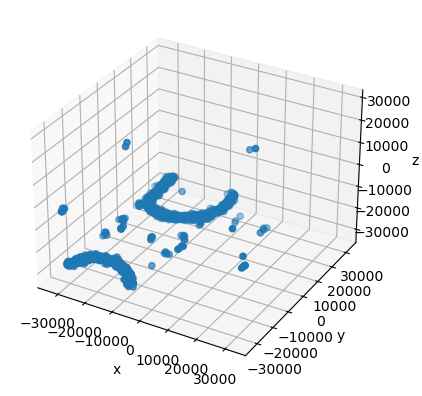

In [8]:
mag_x = df_raw["tw_magn_x"].values.tolist()
mag_y = df_raw["tw_magn_y"].values.tolist()
mag_z = df_raw["tw_magn_z"].values.tolist()

%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(mag_x, mag_y, mag_z)
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

## Fixing the discontinuity jump

In [9]:
mag_x, mag_y, mag_z = np.array(mag_x), np.array(mag_y), np.array(mag_z)
delta = np.max(mag_y) - np.min(mag_y)
mag_y[np.where(mag_y <= 0)] = mag_y[np.where(mag_y <= 0)] + delta

df_raw["tw_magn_y"] = mag_y

(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

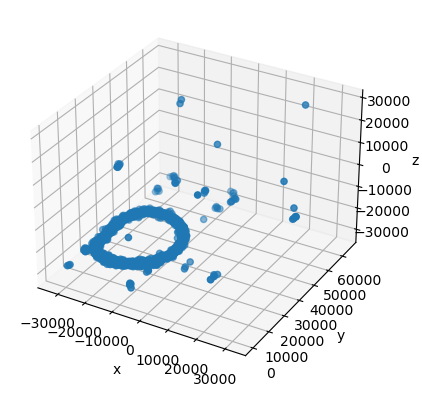

In [10]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(df_raw["tw_magn_x"].values.tolist(), df_raw["tw_magn_y"].values.tolist(), df_raw["tw_magn_z"].values.tolist())
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

## Removing aberrant points

In [12]:
ab1 = np.where(mag_z > -20000)[0]
ab2 = np.where(mag_y > 45000)[0]
ab3 = np.where(mag_y < 10000)[0]
ab4 = np.where(mag_x>=0)[0]
ab5 = np.intersect1d(np.intersect1d(np.where(mag_y < 15000), np.where(mag_z > -28000)), np.where(mag_x < -25000))
ab6 = np.intersect1d(np.intersect1d(
            np.intersect1d(np.where(mag_y < 25000), np.where(mag_y < 25000)),
            np.intersect1d(np.where(mag_y > 20000), np.where(mag_x < -9000))), np.where(mag_x > -11000))
ab7 = np.intersect1d(np.where(mag_x > -10000), np.where(mag_y < 12000))

aberrant_points = np.concatenate([ab1, ab2, ab3, ab4, ab5, ab6, ab7], axis=0)
aberrant_points = np.unique(aberrant_points)

df = df_raw.drop(aberrant_points, axis=0)
df = df.reset_index(drop=True)

(Text(0.5, 0, 'x'), Text(0.5, 0.5, 'y'), Text(0.5, 0, 'z'))

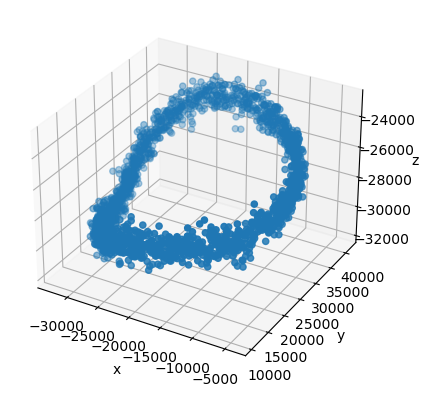

In [13]:
%matplotlib inline
ax = plt.axes(projection='3d')
ax.scatter3D(df["tw_magn_x"], df["tw_magn_y"], df["tw_magn_z"])
ax.set_xlabel("x"), ax.set_ylabel("y"), ax.set_zlabel("z")

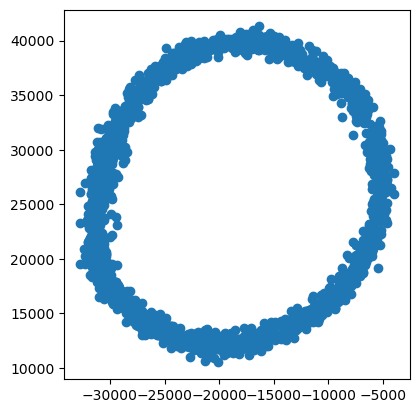

In [14]:
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.scatter(df["tw_magn_x"], df["tw_magn_y"])

## Removing useless data and scaling the dataset

In [15]:
useless_columns = ["time_rx", "src_rx", "lat_rx", "lon_rx", "n_epoch", "timestamp",
                   "service", "subservice", "nsample", "acq_mode", "filter_tempo",
                   "last_anomaly_code", "last_start_source", "recieved_i2c_tc",
                   "processed_i2c_tc", "tw_temp", "tw_state", "tw_res_reason"]
df_cleaned = df.drop(useless_columns, axis=1)

(Text(0.5, 0, 'x'), Text(0, 0.5, 'y'))

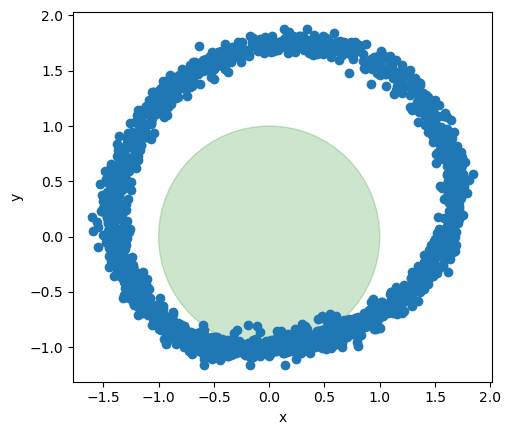

In [16]:
mean =  df_cleaned.mean(axis=0)
std =   df_cleaned.std(axis=0)

df_scaled = (df_cleaned - mean)/std

%matplotlib inline
fig, ax = plt.subplots()
#drawing unit circle
circle = plt.Circle((0, 0), 1, color='g', alpha=0.2)
ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')

plt.scatter(df_scaled["tw_magn_y"], df_scaled["tw_magn_x"])
plt.xlabel("x"), plt.ylabel("y")

## Calibrating magnetometer data

In [17]:
"""Executing the magnetometer calibration script"""
execfile("./my_mag_calib.py")

In [18]:
res = mag_calib(df_scaled)

Text(0, 0.5, 'y')

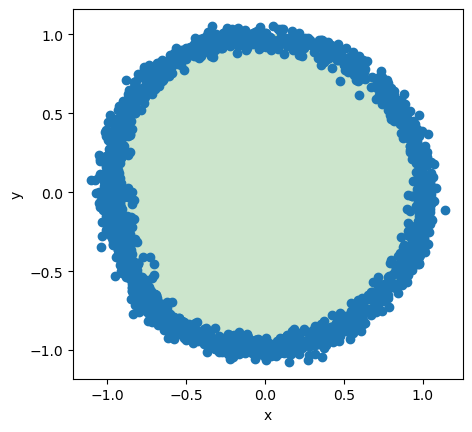

In [19]:
fig, ax = plt.subplots()
circle = plt.Circle((0, 0), 1, color='g', alpha=0.2)
ax.add_patch(circle)
ax.set_aspect('equal', adjustable='box')
plt.scatter(res[0], res[1])
plt.xlabel("x")
plt.ylabel("y")

## Calculating the angle of rotation

(Text(0.5, 0, 'step'), Text(0, 0.5, '$\\theta$'))

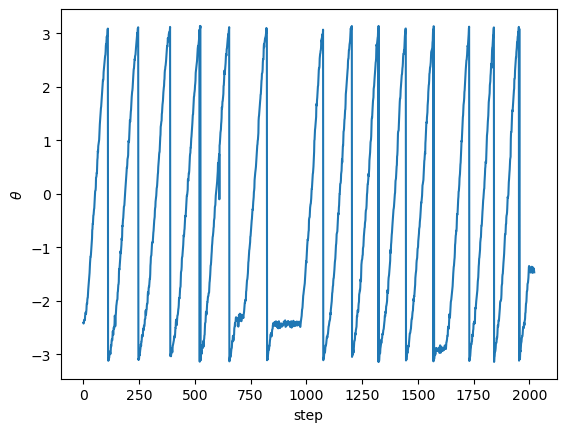

In [20]:
theta = np.arctan2(res[1], res[0])
df_scaled["theta"] = theta

plt.plot(df_scaled["theta"])
plt.xlabel("step"), plt.ylabel("$\\theta$")

# Multivariate analysis

Text(0.5, 1.0, 'Correlation matrix')

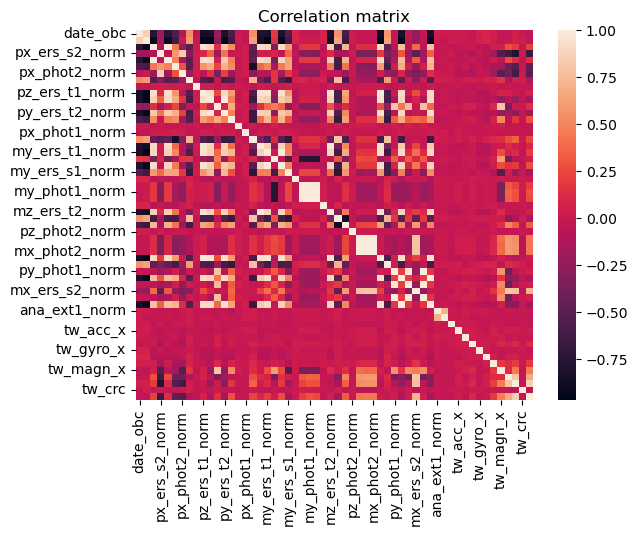

In [21]:
"""correlation matrix"""
%matplotlib inline
sns.heatmap(df_scaled.corr())
plt.title("Correlation matrix")

Text(0.5, 1.0, 'Correlation matrix of highly correlated variables')

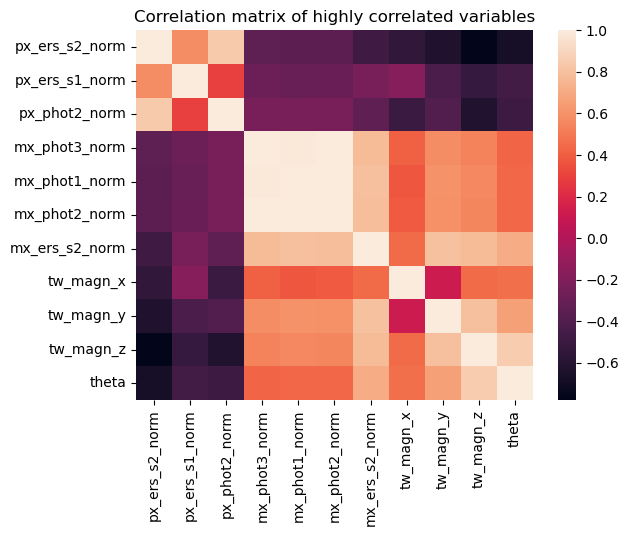

In [22]:
"""Correlation matrix of highly correlated variables"""
theta_corr = df_scaled.corr()["theta"]
high_corr = theta_corr.where(np.abs(theta_corr) > 0.4).dropna().index
df_corr = df_scaled[high_corr]
sns.heatmap(df_corr.corr())
plt.title("Correlation matrix of highly correlated variables")

Text(0.5, 0.98, 'Correlogram of highly correlated variables')

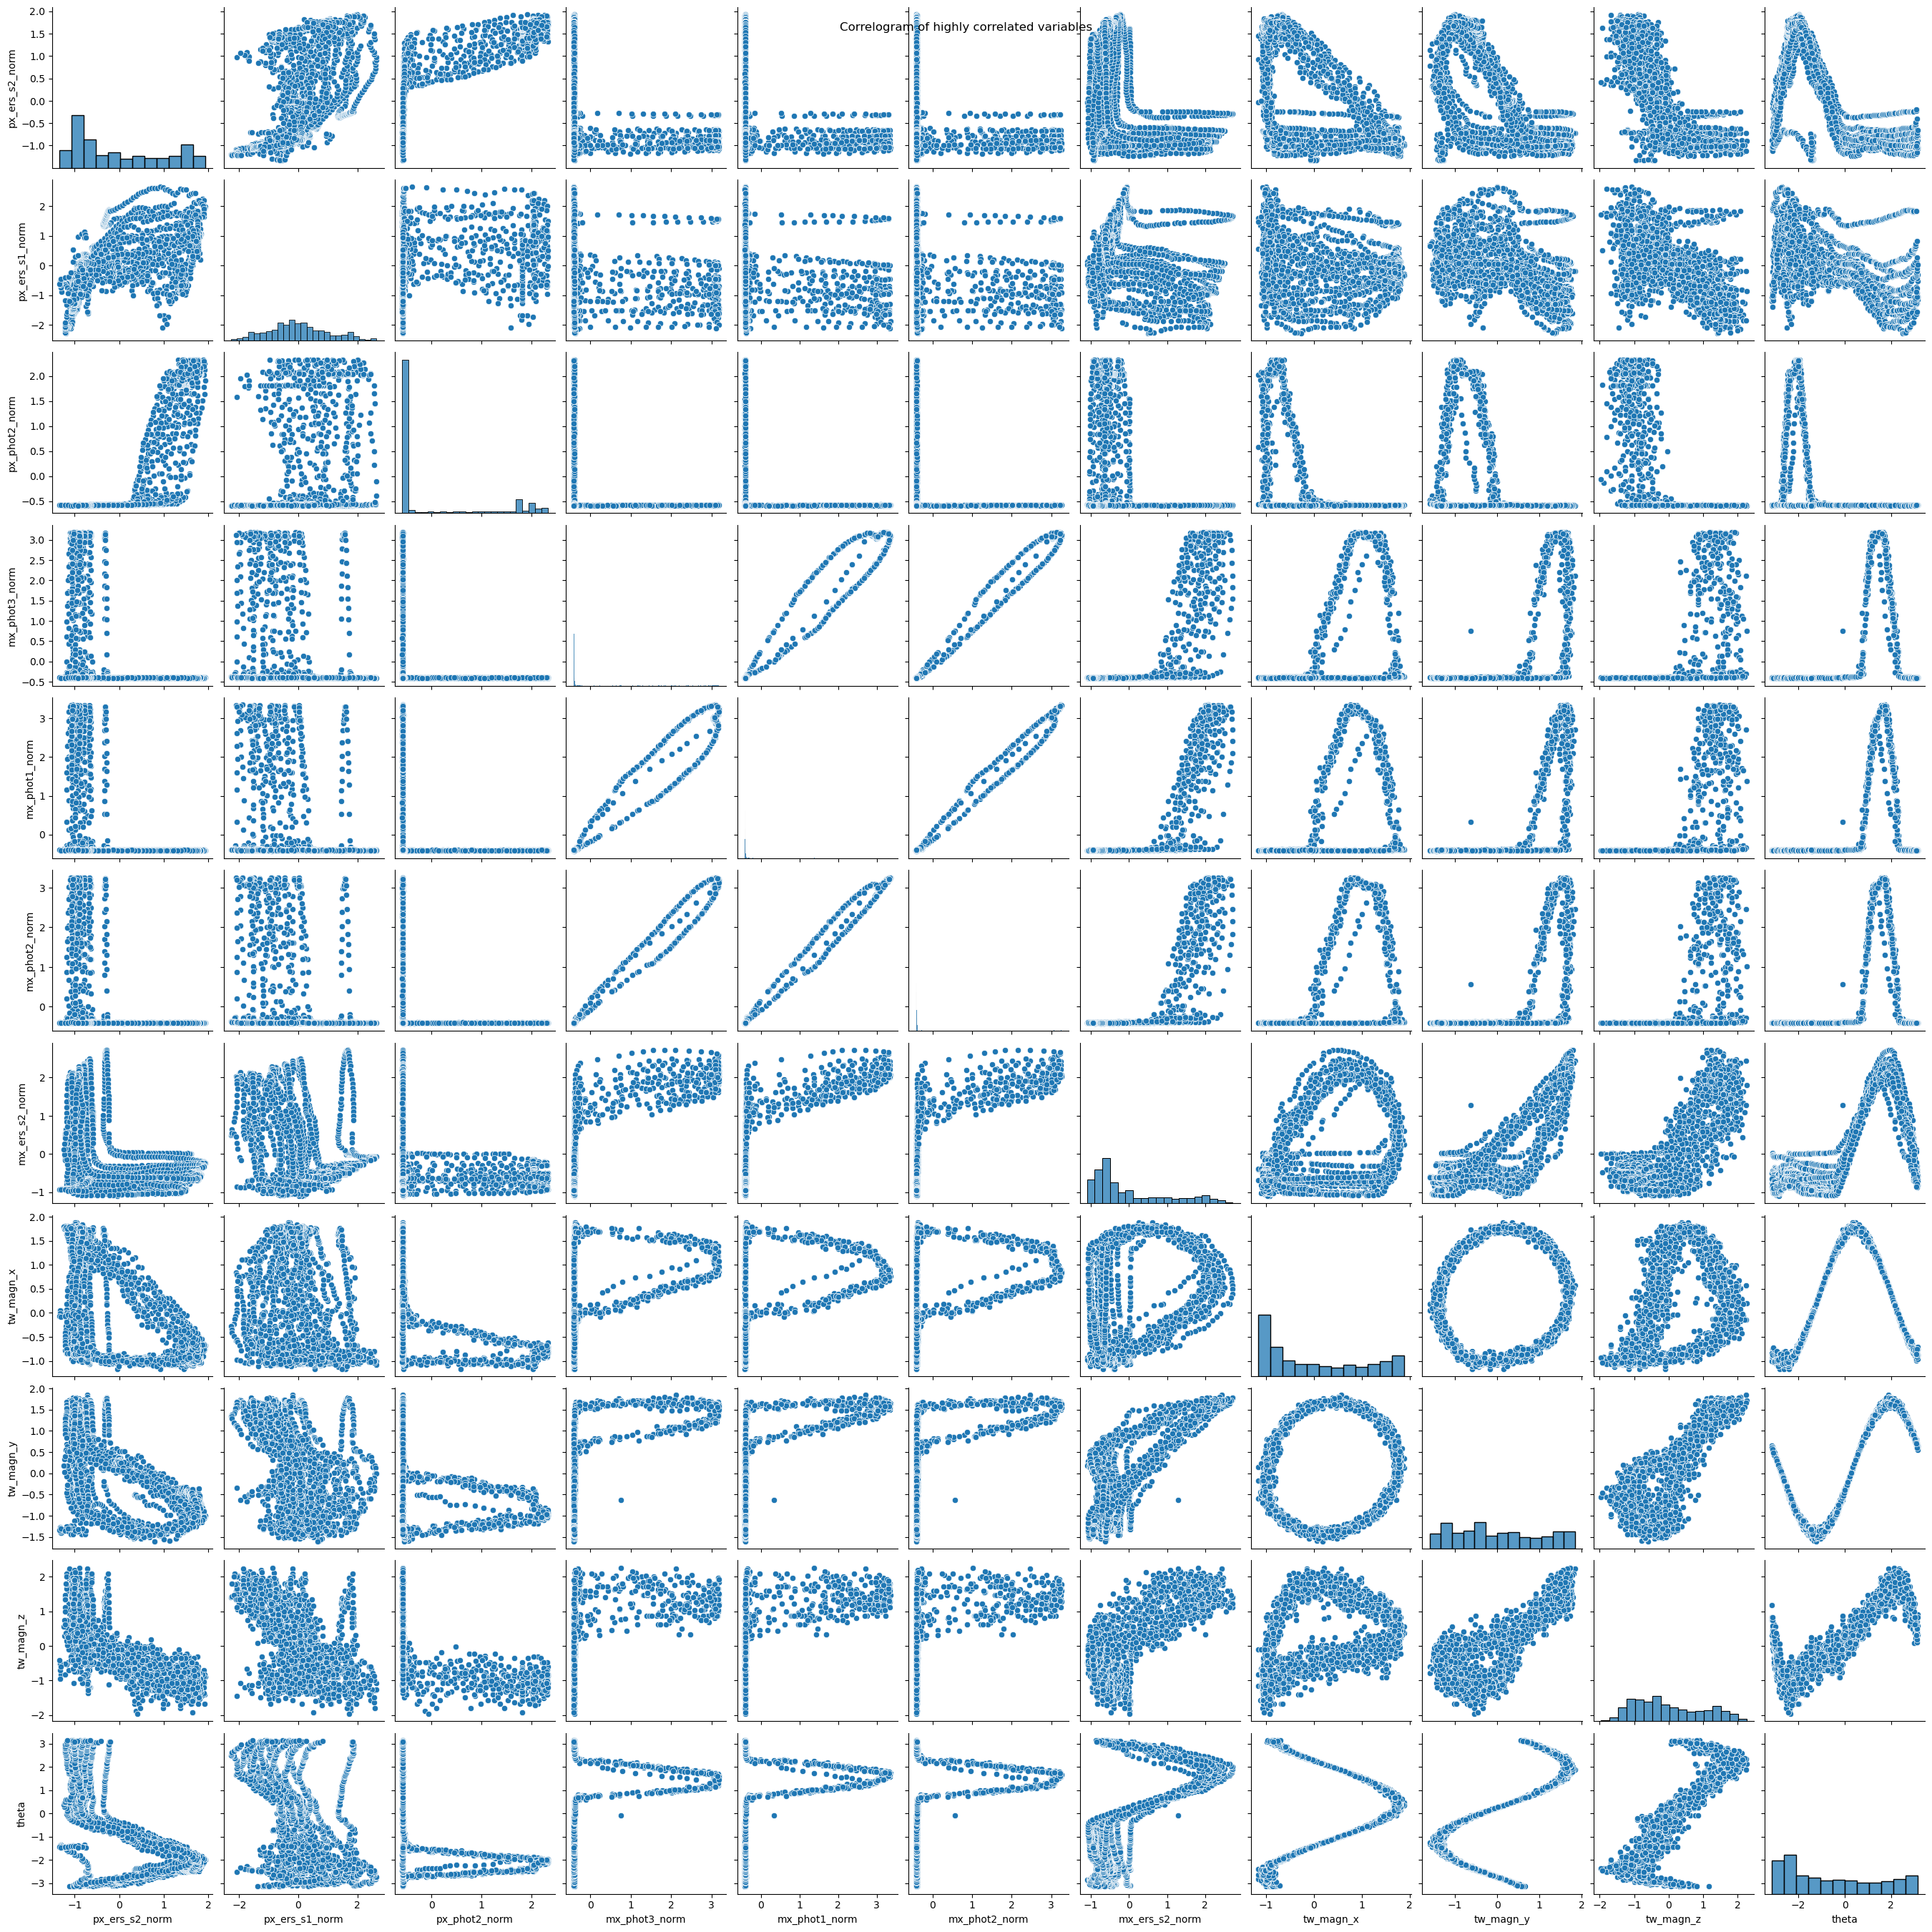

In [23]:
"""correlogram"""
df_trimmed = df_scaled[high_corr]
correlogram = sns.pairplot(df_trimmed)
correlogram.fig.suptitle("Correlogram of highly correlated variables")

# MLP on encoded angle

In [24]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import tqdm
import copy

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
y_columns = ["theta"]
X_removed_columns = ["theta", "tw_magn_x", "tw_magn_y", "tw_magn_z", "date_obc", 'tw_acc_x', 'tw_acc_y', 'tw_acc_z']

X_list = df_scaled.drop(X_removed_columns, axis=1)
y_list = df_scaled[y_columns]

In [27]:
np.random.seed(seed=27)
# train-test split for model evaluation
X_train, X_temp, y_train, y_temp = train_test_split(X_list, y_list, train_size=0.7, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, train_size=0.5, shuffle=True)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test.to_numpy(), dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test.to_numpy(), dtype=torch.float32).to(device)
X_val  = torch.tensor(X_val.to_numpy(), dtype=torch.float32).to(device)
y_val  = torch.tensor(y_val.to_numpy(), dtype=torch.float32).to(device)

In [28]:
y_train = torch.hstack([torch.sin(y_train), torch.cos(y_train)])
y_test  = torch.hstack([torch.sin(y_test), torch.cos(y_test)])
y_val   = torch.hstack([torch.sin(y_val), torch.cos(y_val)])

In [29]:
def encoding_loss(output, input, loss_fn=nn.MSELoss()):
    lbda = 1
    penalty = lbda*torch.mean((1 - torch.linalg.norm(output, dim=1))**2)

    return loss_fn(output, input) + penalty

In [30]:
def choose_angle(row):
    """
    Selection of the element with lowest absolute value
    """
    n0 = np.abs(row[0])
    n1 = np.abs(row[1])
    n2 = np.abs(row[2])

    n = np.array([n0, n1, n2])
    return np.where(n==np.min(n))

def fixed_angle_error(angle, angle_pred):
    """
    fixing the angle discontinuity between 0° and 360°
    """
    np_angle = angle.detach().cpu().numpy()
    np_angle_pred = angle_pred.detach().cpu().numpy()

    np_angle_error = (np_angle - np_angle_pred)*180/np.pi

    
    angle_error_stacked = np.hstack([np_angle_error.reshape((-1,1)), (np_angle_error - 360).reshape((-1,1)), (np_angle_error + 360).reshape((-1,1))])

    angle_index = np.apply_along_axis(func1d=choose_angle, arr=angle_error_stacked, axis=1).squeeze()
    fixed_error = np.apply_along_axis(func1d = lambda i: angle_error_stacked[i, angle_index[i]], arr=np.arange(len(angle_index)), axis=0)

    return fixed_error

Error: 0.01
generalisation Error: 0.007206246256828308
validation Error: 0.004525723401457071
Chosen epoch:       74
test error:         3.0103909969329834°
validation error:   4.069498062133789°


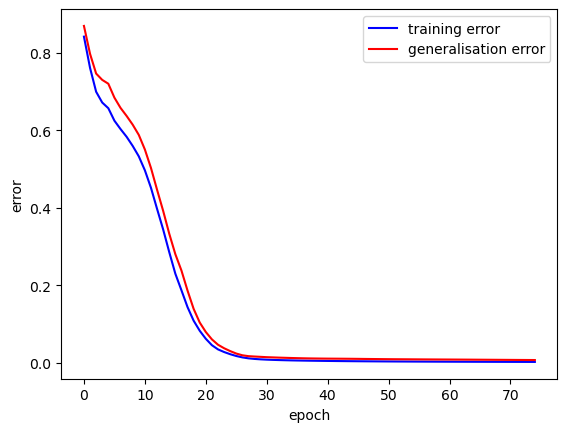

In [31]:
torch.manual_seed(92)

input_size  = X_train.shape[1]
output_size = y_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_size, 92),
    nn.ReLU(),
    nn.Linear(92, 32),
    nn.ReLU(),
    nn.Linear(32, 28),
    nn.ReLU(),
    nn.Linear(28, 10),
    nn.ReLU(),
    nn.Linear(10, output_size)
).to(device)

# loss function and optimizer
loss_fn = encoding_loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 75  # number of epochs to run
batch_size = 350  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_error = np.inf   # init to infinity
best_weights = None
training_error_list = []
generalisation_error_list = []
min_epoch = 0

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(error=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    #training error
    training_error_list.append(float(loss_fn(model(X_train), y_train)))
    #generalisation error
    y_pred = model(X_test)
    generalisation_error = loss_fn(y_pred, y_test)
    generalisation_error = float(generalisation_error)
    generalisation_error_list.append(generalisation_error)
    if generalisation_error < best_error:
        best_error = generalisation_error
        best_weights = copy.deepcopy(model.state_dict())
        min_epoch = epoch

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("Error: %.2f" % best_error)

test_error  = loss_fn(model(X_test), y_test)

y_pred = model(X_val)
val_error   = loss_fn(y_pred, y_val)

print(f"generalisation Error: {test_error}")
print(f"validation Error: {val_error}")

y_train_pred = model(X_train)
train_angle         = torch.atan2(y_train[:,0], y_train[:,1])
train_angle_pred    = torch.atan2(y_train_pred[:,0], y_train_pred[:,1])
train_angle_error   = torch.abs(train_angle - train_angle_pred)

fixed_train_error = fixed_angle_error(train_angle, train_angle_pred)

angle       = torch.atan2(y_val[:,0], y_val[:,1])
angle_pred  = torch.atan2(y_pred[:,0], y_pred[:,1])
angle_error = torch.abs(angle - angle_pred)

fixed_error = fixed_angle_error(angle, angle_pred)

print(f"Chosen epoch:       {min_epoch}")
print(f"test error:         {np.std(fixed_train_error)}°")
print(f"validation error:   {np.std(fixed_error)}°")

plt.plot(training_error_list, c="blue")
plt.plot(generalisation_error_list, c="red")
plt.legend(["training error", "generalisation error"])
plt.xlabel("epoch"), plt.ylabel("error")
plt.show()

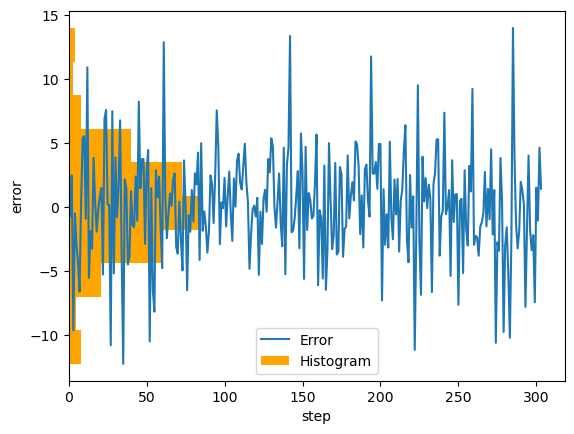

In [36]:
plt.plot(fixed_error)
plt.hist(fixed_error, orientation="horizontal", color="orange")
plt.xlabel("step"), plt.ylabel("error")
plt.legend(["Error", "Histogram"])

In [33]:
np_mean = np.mean(np.abs(fixed_error))
np_std  = np.std(fixed_error)

print(f"MEAN error  :{'%.2f' % np_mean}°")
print(f"STD         :{'%.2f' % np_std}°")

MEAN error  :3.10°
STD         :4.07°


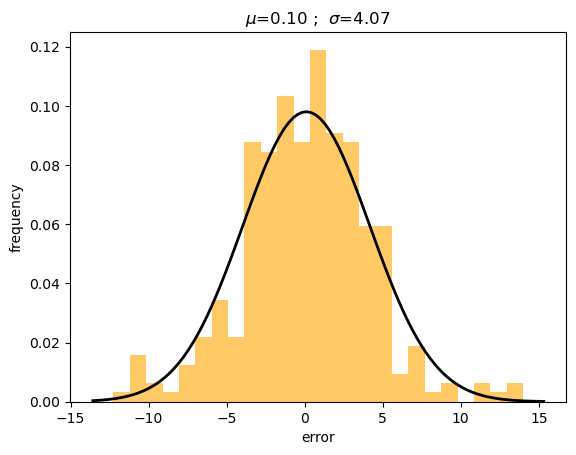

In [37]:
# Fitting normal distribution
mu, std = scipy.stats.norm.fit(fixed_error) 
  
# Plot the histogram.
plt.hist(fixed_error, bins=25, density=True, alpha=0.6, color="orange")

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = scipy.stats.norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2)
plt.title("$\mu$={:.2f} ;  $\sigma$={:.2f}".format(mu, std))

plt.xlabel("error"), plt.ylabel("frequency")
plt.show()